In [1]:
import sys
sys.path.append('..')
import pandas as pd
from datetime import datetime
import os

from core.models.utils import run_spark_session
pd.set_option('display.max.columns',300)

from core.calculator.storage import ModelDB
from core.calculator.core import BackTestHonestConfig, BackTestHonestEngine
from core.calculator.core import TrainingManager

from core.calculator.deposits import DepositsCalculationType, DepositIterativeCalculator

from core.definitions import *

from core.models import DepositModels, ScenarioLoader
from warnings import filterwarnings
import plotly.express as px
filterwarnings('ignore')
import pickle

In [ ]:
spark = run_spark_session('run_backtest_analyzer')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/21 20:21:12 WARN util.Utils: Service 'sparkDriver' could not bind on port 31120. Attempting port 31121.
23/12/21 20:21:12 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/21 20:21:14 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/12/21 20:21:15 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/12/21 20:21:15 WARN yarn.Client: Same path resource file:///opt/cloudera/parcels/AnacondaPy37/jars/spark-tree-plotting-0.

In [ ]:
folder = '../data/trained_models'

sqlite_filepath = os.path.join(folder, 'modeldb_test.bin')

DB_URL = f"sqlite:///{sqlite_filepath}"
model_db = ModelDB(DB_URL)

In [ ]:
last_train_dt = datetime(year=2023, month=6, day=30)
steps = 1
horizon = 3

In [ ]:
DepositModels.trainers

In [ ]:
ENV_NAME = 'hmelevskoi_env'

os.environ['CC'] = 'x86_64-conda-linux-gnu-gcc'
os.environ['CXX'] = 'x86_64-conda-linux-gnu-g++'
os.environ['PATH'] = os.path.abspath(f'/tmp/envs/{ENV_NAME}/bin') + ':' + os.environ['PATH']

In [ ]:
config: BackTestHonestConfig = BackTestHonestConfig(
    first_train_end_dt = last_train_dt,
    horizon = horizon,
    steps = steps,
    trainers = DepositModels.trainers,
    data_loaders = DepositModels.dataloaders,
    calculator_type = DepositIterativeCalculator,
    calc_type = DepositsCalculationType.Deposits.Deposits,
    adapter_types = DepositModels.adapter_types,
    scenario_loader = ScenarioLoader()
)
training_manager = TrainingManager(spark, DepositModels.trainers, folder, model_db)   
engine: BackTestHonestEngine = BackTestHonestEngine(spark, config, training_manager, overwrite_models=False) 

In [ ]:
%%time
engine.run_all()

### Посмотрим что посылается в модель досрочки в калькуляторе

In [20]:
er_dict = engine._calc_results[1]

In [50]:
with open('er_dict.pickle', 'wb') as fo:
    pickle.dump(er_dict, fo)

In [51]:
with open('er_dict.pickle', 'rb') as fo:
    er_dict = pickle.load(fo)

In [52]:
er_dict.keys()

dict_keys(['forecast_dates', 'curr_portfolio', 'curr_normal_port', 'curr_weird_port', 'reg', 'target', 'features', 'model_meta[3]', 'model_meta[4]', 'model_meta[5]', 'curr_portfolio_pred_normal', 'curr_portfolio_pred_weird', 'ew_curr_portfolio_pred ', 'newbusiness_pred', 'cols_to_split', 'labels', 'tresholds'])

In [54]:
for k, v in er_dict.items():
    if k in ['forecast_dates', 'reg', 'target', 'features', 'model_meta[3]', 'model_meta[4]', 'model_meta[5]', 'cols_to_split', 'labels', 'tresholds']:
        display(v)

[datetime.datetime(2023, 2, 28, 0, 0)]

Dep. Variable:,SER_dinamic_cl,R-squared:,0.4735
Estimator:,PanelOLS,R-squared (Between):,0.5685
No. Observations:,41392,R-squared (Within):,0.2844
Date:,"Fri, Nov 10 2023",R-squared (Overall):,0.4735
Time:,22:08:42,Log-likelihood,8.567e+04
Cov. Estimator:,Robust,,
,,F-statistic:,2325.6
Entities:,7285,P-value,0.0000
Avg Obs:,5.6818,Distribution:,"F(16,41376)"
Min Obs:,0.0000,,
Max Obs:,59.000,F-statistic (robust):,480.34


'SER_dinamic_cl'

['incentive', 'incentive_lag1', 'share_period_plan']

['months_left', 'incentive']

['lft', 'inc']

[5.0, -4.43096168]

['months_left', 'incentive']

['lft', 'inc']

[[5.0], [-4.43096168]]

In [36]:
display(
    er_dict['curr_portfolio'][['report_month', 'open_month']].max()#.describe(),
    ,er_dict['curr_portfolio'].columns
)

report_month    2023-01
open_month      2023-01
dtype: object

Index(['report_month', 'bucketed_balance', 'is_vip_or_prv', 'drop_flg',
       'optional_flg', 'bucketed_period', 'open_month', 'close_month',
       'bucketed_open_rate', 'report_dt', 'total_interests',
       'remaining_interests', 'weight_rate', 'total_generation',
       'total_generation_cleared', 'weight_renewal_cnt',
       'weight_renewal_available_flg', 'weight_close_plan_day', 'gen_name',
       'SER_d', 'SER_d_cl', 'SER_dinamic', 'SER_dinamic_cl',
       'total_generation_lag1', 'total_generation_cl_lag1', 'CUR',
       'report_weight_open_rate_1m', 'report_weight_open_rate_3m',
       'report_weight_open_rate_6m', 'report_weight_open_rate_12m',
       'report_weight_open_rate_24m', 'report_wo_period_weight_open_rate',
       'init_total_generation', 'row_count', 'share_period_plan',
       'max_total_generation', 'max_SER_dinamic',
       'renewal_balance_next_month'],
      dtype='object')

In [56]:
display(
    er_dict['curr_normal_port'][['report_month', 'open_month']].min(),
    er_dict['curr_normal_port'][['report_month', 'open_month']].max()#.describe(),
    ,er_dict['curr_normal_port'].columns
)

report_month    2023-01
open_month      2018-03
dtype: object

report_month    2023-01
open_month      2023-01
dtype: object

Index(['report_month', 'bucketed_balance', 'is_vip_or_prv', 'drop_flg',
       'optional_flg', 'bucketed_period', 'open_month', 'close_month',
       'bucketed_open_rate', 'report_dt', 'total_interests',
       'remaining_interests', 'weight_rate', 'total_generation',
       'total_generation_cleared', 'weight_renewal_cnt',
       'weight_renewal_available_flg', 'weight_close_plan_day', 'gen_name',
       'SER_d', 'SER_d_cl', 'SER_dinamic', 'SER_dinamic_cl',
       'total_generation_lag1', 'total_generation_cl_lag1', 'CUR',
       'report_weight_open_rate_1m', 'report_weight_open_rate_3m',
       'report_weight_open_rate_6m', 'report_weight_open_rate_12m',
       'report_weight_open_rate_24m', 'report_wo_period_weight_open_rate',
       'init_total_generation', 'row_count', 'share_period_plan',
       'max_total_generation', 'max_SER_dinamic', 'renewal_balance_next_month',
       'weird_flag', 'max_rate', 'spread_weight_rate_&_weight_open_rate',
       'spread_weight_rates_wo_period', 

In [55]:
display(
    er_dict['curr_portfolio_pred_normal'][['report_month', 'open_month']].min(),
    er_dict['curr_portfolio_pred_normal'][['report_month', 'open_month']].max()#.describe(),
    ,er_dict['curr_portfolio_pred_normal'].columns
)

report_month    2023-02
open_month      2018-03
dtype: object

report_month    2023-02
open_month      2023-01
dtype: object

Index(['report_month', 'bucketed_balance', 'is_vip_or_prv', 'drop_flg',
       'optional_flg', 'bucketed_period', 'open_month', 'close_month',
       'bucketed_open_rate', 'report_dt', 'total_interests',
       'remaining_interests', 'weight_rate', 'total_generation',
       'total_generation_cleared', 'weight_renewal_cnt',
       'weight_renewal_available_flg', 'weight_close_plan_day', 'gen_name',
       'SER_d', 'SER_d_cl', 'SER_dinamic', 'SER_dinamic_cl',
       'total_generation_lag1', 'total_generation_cl_lag1', 'CUR',
       'report_weight_open_rate_1m', 'report_weight_open_rate_3m',
       'report_weight_open_rate_6m', 'report_weight_open_rate_12m',
       'report_weight_open_rate_24m', 'report_wo_period_weight_open_rate',
       'init_total_generation', 'row_count', 'share_period_plan',
       'max_total_generation', 'max_SER_dinamic'],
      dtype='object')

In [47]:
display(
    er_dict['newbusiness_pred'][['report_month', 'open_month']].max()#.describe(),
    ,er_dict['newbusiness_pred'].columns
)


report_month    2023-02
open_month      2023-02
dtype: object

Index(['report_month', 'bucketed_balance', 'is_vip_or_prv', 'drop_flg',
       'optional_flg', 'bucketed_period', 'open_month', 'close_month',
       'bucketed_open_rate', 'report_dt', 'total_interests',
       'remaining_interests', 'weight_rate', 'total_generation',
       'total_generation_cleared', 'weight_renewal_cnt',
       'weight_renewal_available_flg', 'weight_close_plan_day', 'gen_name',
       'SER_d', 'SER_d_cl', 'SER_dinamic', 'SER_dinamic_cl',
       'total_generation_lag1', 'total_generation_cl_lag1', 'CUR',
       'report_weight_open_rate_1m', 'report_weight_open_rate_3m',
       'report_weight_open_rate_6m', 'report_weight_open_rate_12m',
       'report_weight_open_rate_24m', 'report_wo_period_weight_open_rate',
       'init_total_generation', 'row_count', 'share_period_plan',
       'max_total_generation', 'max_SER_dinamic'],
      dtype='object')

In [64]:
display(
    data.columns, 
    er_dict['curr_normal_port'].columns
)


Index(['report_month', 'bucketed_balance', 'is_vip_or_prv', 'drop_flg',
       'optional_flg', 'bucketed_period', 'open_month', 'close_month',
       'bucketed_open_rate', 'report_dt', 'avg_contract_period',
       'avg_init_balance_amt', 'avg_end_balance_amt', 'total_interests',
       'remaining_interests', 'avg_rate', 'weight_rate',
       'early_close_generation', 'total_generation',
       'total_generation_cleared', 'count_agreements',
       'mean_renewal_available_flg', 'weight_renewal_cnt',
       'weight_renewal_available_flg', 'weight_close_plan_day', 'gen_name',
       'SER_d', 'SER_d_cl', 'SER', 'SER_cl', 'SER_dinamic', 'SER_dinamic_cl',
       'total_generation_lag1', 'total_generation_cl_lag1', 'CUR',
       'report_perc_10', 'report_mean_open_rate', 'report_weight_open_rate',
       'report_perc_90', 'report_weight_open_rate_1m',
       'report_weight_open_rate_3m', 'report_weight_open_rate_6m',
       'report_weight_open_rate_12m', 'report_weight_open_rate_24m',
      

Index(['report_month', 'bucketed_balance', 'is_vip_or_prv', 'drop_flg',
       'optional_flg', 'bucketed_period', 'open_month', 'close_month',
       'bucketed_open_rate', 'report_dt', 'total_interests',
       'remaining_interests', 'weight_rate', 'total_generation',
       'total_generation_cleared', 'weight_renewal_cnt',
       'weight_renewal_available_flg', 'weight_close_plan_day', 'gen_name',
       'SER_d', 'SER_d_cl', 'SER_dinamic', 'SER_dinamic_cl',
       'total_generation_lag1', 'total_generation_cl_lag1', 'CUR',
       'report_weight_open_rate_1m', 'report_weight_open_rate_3m',
       'report_weight_open_rate_6m', 'report_weight_open_rate_12m',
       'report_weight_open_rate_24m', 'report_wo_period_weight_open_rate',
       'init_total_generation', 'row_count', 'share_period_plan',
       'max_total_generation', 'max_SER_dinamic', 'renewal_balance_next_month',
       'weird_flag', 'max_rate', 'spread_weight_rate_&_weight_open_rate',
       'spread_weight_rates_wo_period', 

In [57]:
name = 'deposit_earlyredemption_mass_R0S0_RUR'

data = engine._config.data_loaders[name].get_training_data(spark, engine._config.data_loaders[name].start_date, last_train_dt)['data']

[Stage 5:>                                                          (0 + 1) / 1]23/12/19 15:35:24 ERROR cluster.YarnScheduler: Lost executor 19 on p0drp0-db5039xp.region.vtb.ru: Unable to create executor due to Address already in use: Service 'org.apache.spark.network.netty.NettyBlockTransferService' failed after 5 retries (starting from 61555)! Consider explicitly setting the appropriate port for the service 'org.apache.spark.network.netty.NettyBlockTransferService' (for example spark.ui.port for SparkUI) to an available port or increasing spark.port.maxRetries.
23/12/19 15:35:24 ERROR cluster.YarnScheduler: Lost executor 12 on p0drp0-db5039xp.region.vtb.ru: Unable to create executor due to Address already in use: Service 'org.apache.spark.network.netty.NettyBlockTransferService' failed after 5 retries (starting from 61555)! Consider explicitly setting the appropriate port for the service 'org.apache.spark.network.netty.NettyBlockTransferService' (for example spark.ui.port for SparkUI

In [59]:
with open('er_data.pickle', 'wb') as fo:
    pickle.dump(data, fo)

In [60]:
with open('er_data.pickle', 'rb') as fo:
    data = pickle.load(fo)

## Пытаемся получить предикт методами адаптера

In [65]:
er_model = engine.register.get_model(engine.trained_models[(1, name)])

In [67]:
data.head()

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,avg_contract_period,avg_init_balance_amt,avg_end_balance_amt,total_interests,remaining_interests,avg_rate,weight_rate,early_close_generation,total_generation,total_generation_cleared,count_agreements,mean_renewal_available_flg,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER,SER_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_perc_10,report_mean_open_rate,report_weight_open_rate,report_perc_90,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_perc_10,report_wo_period_mean_open_rate,report_wo_period_weight_open_rate,report_wo_period_perc_90,report_wo_period_wo_opt_perc_10,report_wo_period_wo_opt_mean_open_rate,report_wo_period_wo_opt_weight_open_rate,report_wo_period_wo_opt_perc_90,init_weight_rate,init_total_generation,init_count_agreements,row_count,share_period,days_passed,days_plan,share_period_plan,max_total_generation,max_SER_dinamic
0,2014-01,4.0,0,0.0,0,37.0,2011-05,2014-05,8.0,2014-01-31,1095.000000,1000000.000,1000000.000,204600.000000,248000.000000,7.440000,7.440000,0.0,1000000.00,1000000.00,1,1.0,0.0,1.0,4.000000,2011-05_2014-05_4.0_37.0_8.0_0_0_0.0_RUR,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1000000.0,RUR,7.250,7.367857,7.370154,7.65,5.518648,5.881069,6.956455,7.156846,7.138885,5.80,7.502291,7.496342,10.00,5.25,6.485748,6.435703,7.75,7.440000,2000000.00,2,33,0.916667,976,1096,0.890511,1000000.00,0.0
1,2014-02,4.0,0,0.0,0,37.0,2011-05,2014-05,8.0,2014-02-28,1095.000000,1000000.000,1000000.000,210800.000000,241800.000000,7.440000,7.440000,0.0,1000000.00,1000000.00,1,1.0,0.0,1.0,4.000000,2011-05_2014-05_4.0_37.0_8.0_0_0_0.0_RUR,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1000000.0,RUR,7.160,7.300000,7.312293,7.65,5.526863,5.897365,6.913947,7.120968,7.117224,5.80,7.588782,7.566597,10.00,4.20,6.406803,6.351090,7.75,7.440000,2000000.00,2,34,0.944444,1007,1096,0.918796,1000000.00,0.0
2,2014-03,4.0,0,0.0,0,37.0,2011-05,2014-05,8.0,2014-03-31,1095.000000,1000000.000,1000000.000,217000.000000,235600.000000,7.440000,7.440000,0.0,1000000.00,1000000.00,1,1.0,0.0,1.0,4.000000,2011-05_2014-05_4.0_37.0_8.0_0_0_0.0_RUR,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1000000.0,RUR,7.225,7.308333,7.307561,7.45,5.519290,5.825900,7.199473,7.132277,7.165021,5.80,8.055013,8.052311,10.00,5.25,6.782471,6.736724,10.00,7.440000,2000000.00,2,35,0.972222,1035,1096,0.944343,1000000.00,0.0
3,2014-04,4.0,0,0.0,0,37.0,2011-05,2014-05,8.0,2014-04-30,1095.000000,1000000.000,1000000.000,223200.000000,229400.000000,7.440000,7.440000,0.0,1000000.00,1000000.00,1,1.0,0.0,1.0,4.000000,2011-05_2014-05_4.0_37.0_8.0_0_0_0.0_RUR,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1000000.0,RUR,NaN,NaN,NaN,NaN,5.533451,5.784611,7.439348,8.145635,7.058209,7.50,7.872046,7.868914,8.25,5.25,6.971756,6.927182,8.25,7.440000,2000000.00,2,36,1.000000,1066,1096,0.972628,1000000.00,0.0
4,2014-01,2.0,0,0.0,0,25.0,2013-01,2015-01,9.0,2014-01-31,729.666667,289479.385,289479.385,165311.372174,152595.112776,8.758333,8.785606,0.0,1736876.31,1736876.31,6,1.0,0.0,1.0,19.494002,2013-01_2015-01_2.0_25.0_9.0_0_0_0.0_RUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUR,6.800,6.892857,6.878698,7.20,5.350000,5.739996,6.884742,7.000058,6.878698,5.35,7.757929,7.685066,10.00,5.20,6.801686,6.816265,10.00,8.785606,1736876.31,6,1,0.076923,365,730,0.500000,1736876.31,0.0


In [76]:
er_model._port_max_rates(data)

0         7.156846
1         7.120968
2         7.199473
3         8.145635
4         7.000058
            ...   
231642    7.859129
231643    7.590569
231644    7.511369
231645    7.490064
231646    7.511369
Length: 205498, dtype: float64

In [77]:
portfolio = data.copy()
portfolio.loc[:, 'max_rate'] = er_model._port_max_rates(portfolio)

portfolio.loc[:, 'spread_weight_rate_&_weight_open_rate'] = (
            portfolio.loc[:, 'weight_rate'] - portfolio.loc[:, 'max_rate']
    )

portfolio.loc[:,'spread_weight_rates_wo_period'] = portfolio.loc[:,'weight_rate'] - portfolio.loc[:,'report_wo_period_weight_open_rate']
       
portfolio.loc[:, 'months_passed'] = portfolio['row_count'] - 1
portfolio.loc[:, 'months_left'] = portfolio['bucketed_period'] + 1 - portfolio['months_passed']

portfolio.loc[portfolio['optional_flg'].isin([1,3]), 'incentive'] = portfolio.loc[portfolio['optional_flg'].isin([1,3]), 'spread_weight_rates_wo_period']

# Для вкладов без опции снятия
portfolio.loc[portfolio['optional_flg'].isin([0,2]), 'incentive'] = portfolio.loc[portfolio['optional_flg'].isin([0,2]), 'spread_weight_rate_&_weight_open_rate']
portfolio.loc[:,'incentive_lag1'] = portfolio.groupby('gen_name')['incentive'].shift()

In [92]:
portfolio = portfolio.dropna (subset = ['incentive', 'incentive_lag1'])

In [95]:
data.count()

report_month            205498
bucketed_balance        205498
is_vip_or_prv           205498
drop_flg                205498
optional_flg            205498
                         ...  
days_passed             205498
days_plan               205498
share_period_plan       205498
max_total_generation    205498
max_SER_dinamic         204816
Length: 62, dtype: int64

In [98]:
from core.models.early_withdrawal.base_model import early_redemption_ptr_transform

port_mod, exog_vars = early_redemption_ptr_transform( 
            portfolio,
            er_model.cols_to_split, 
            er_model.labels, 
            er_model.tresholds, 
            er_model.features
)


preds = (
            er_model.reg
            .predict(
                port_mod
                .set_index(['gen_name', 'report_dt'])
                [exog_vars]
            )
            .reset_index(drop=False)
        )

In [113]:
preds.describe()

,predictions
count,183182.000000
mean,-0.021162
std,0.030851
min,-0.353638
25%,-0.024598
50%,-0.017588
75%,-0.010401
max,0.213127


In [141]:
[col for col in portfolio.columns if col.startswith('SER') or col.startswith('total')]

['total_interests',
 'total_generation',
 'total_generation_cleared',
 'SER_d',
 'SER_d_cl',
 'SER',
 'SER_cl',
 'SER_dinamic',
 'SER_dinamic_cl',
 'total_generation_lag1',
 'total_generation_cl_lag1']

In [150]:
(pred_truth.groupby('report_dt').agg({'total_truth': 'sum', 'SER_d_cl': 'sum'})['total_truth'] - pred_truth.groupby('report_dt').agg({'total_truth': 'sum', 'SER_d_cl': 'sum'})['SER_d_cl']).max()


58766.471841812134

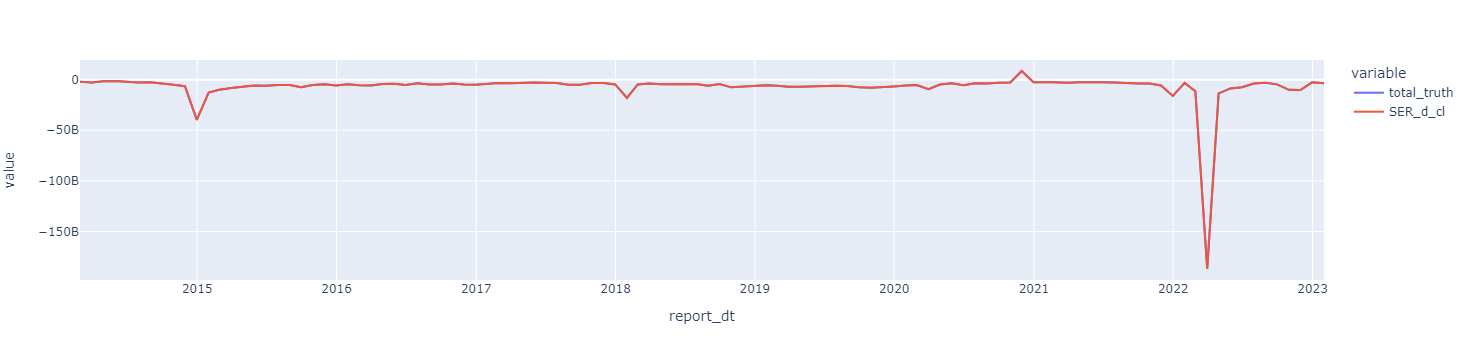

In [152]:
px.line(pred_truth.groupby('report_dt').agg({'total_truth': 'sum', 'SER_d_cl': 'sum'}))

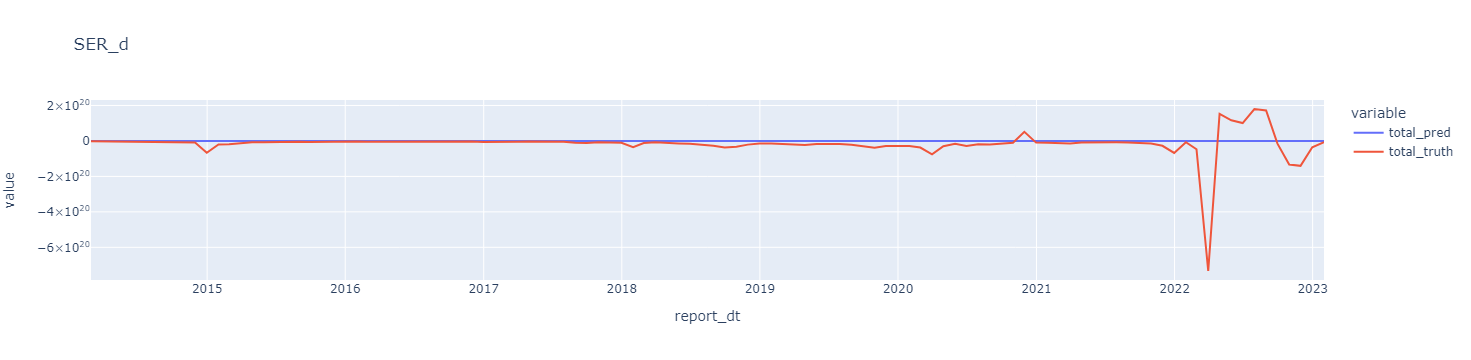

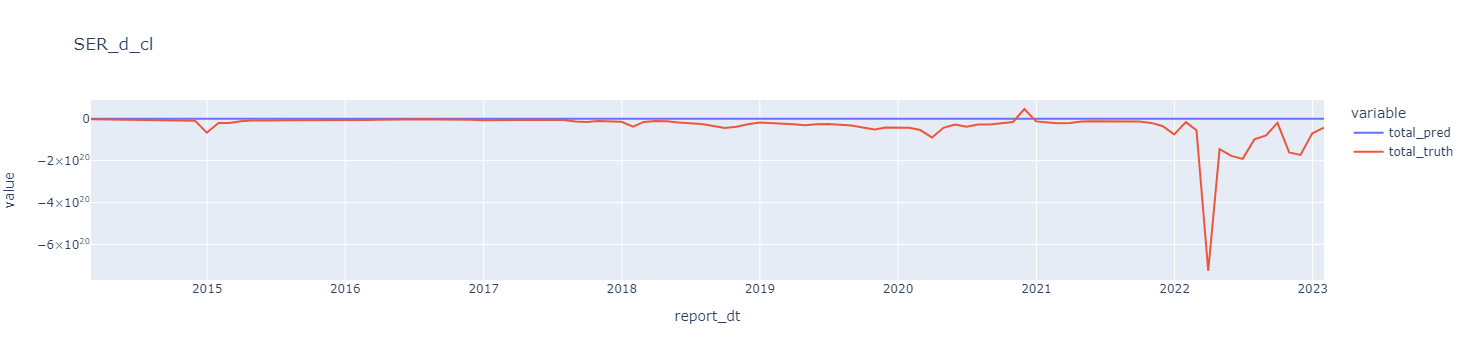

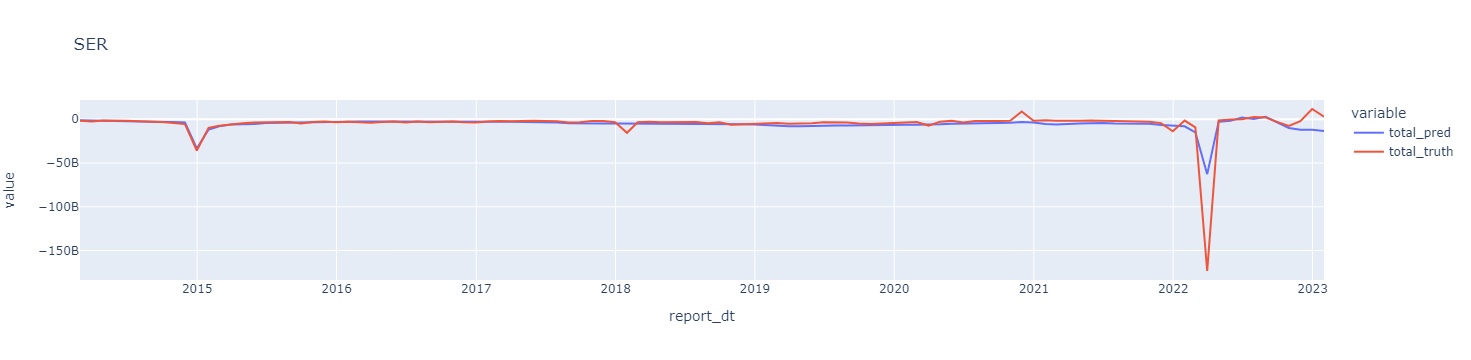

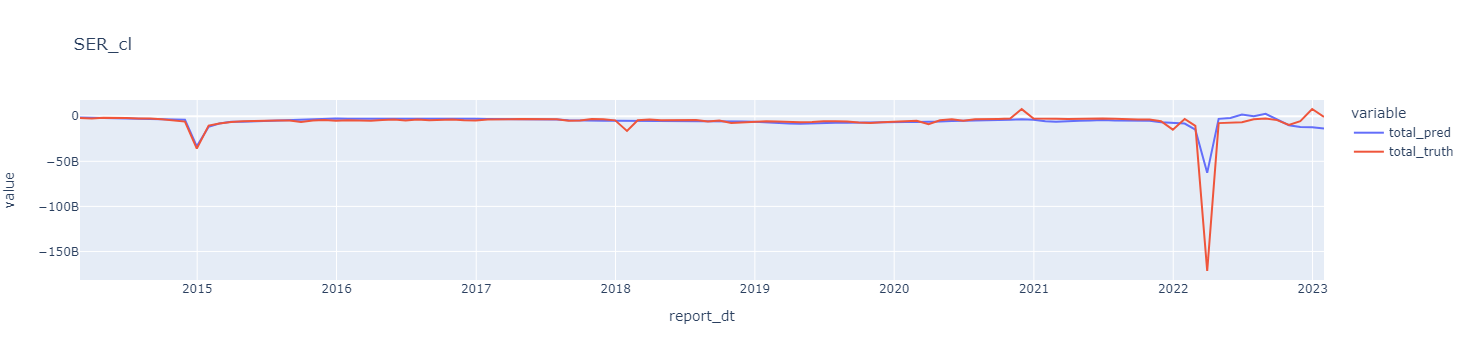

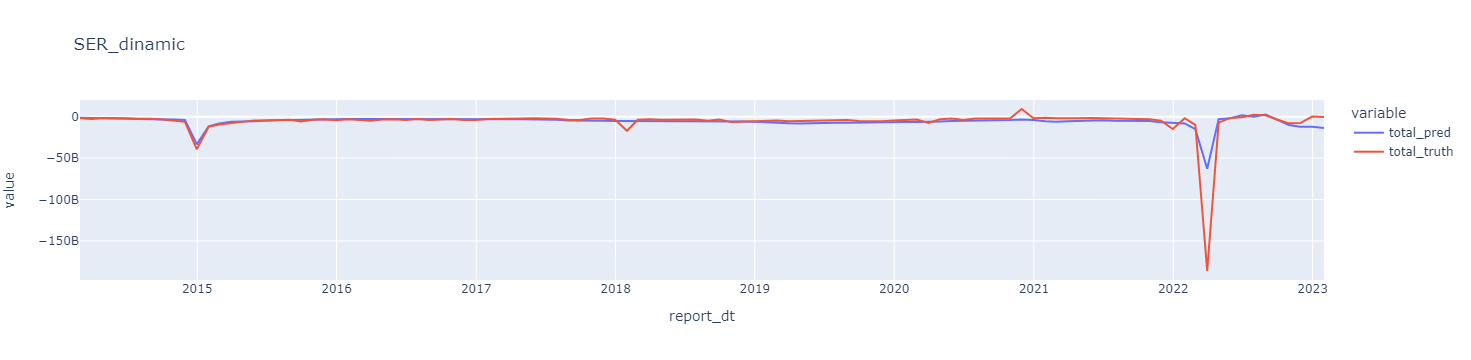

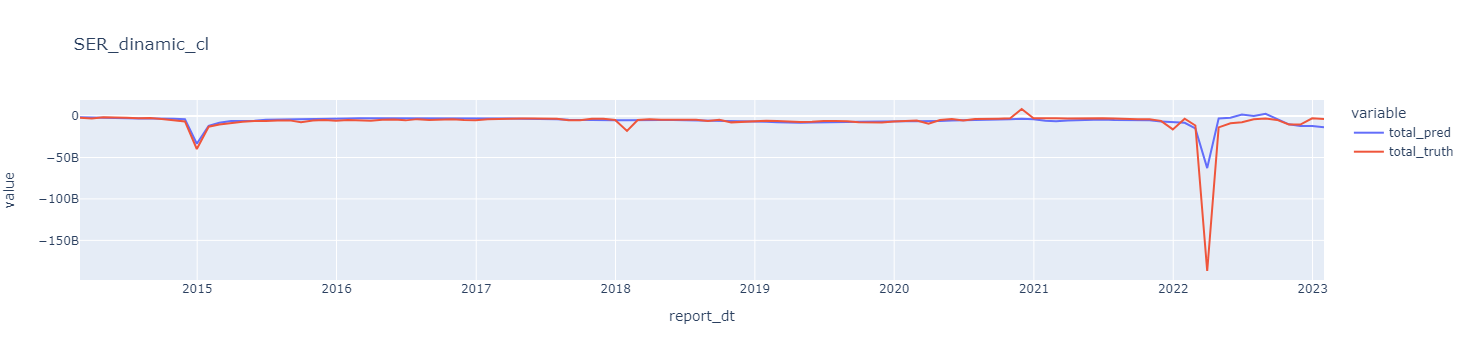

In [142]:
pred_truth = portfolio.merge(preds, on = ['gen_name', 'report_dt'])
for col in [col for col in portfolio.columns if col.startswith('SER')]:
    pred_truth = pred_truth.assign(total_truth = pred_truth[col] * pred_truth['total_generation_cl_lag1'], total_pred = pred_truth['predictions'] * pred_truth['total_generation_cl_lag1'])
    px.line(pred_truth.groupby('report_dt').agg({'total_pred': 'sum', 'total_truth': 'sum'}), title = col).show()
    

In [140]:
DepositModels.trainers[name].model_class_kwargs

{'target': 'SER_dinamic_cl',
 'leaf_reg_features': ['incentive', 'incentive_lag1', 'share_period_plan'],
 'splitting_cols': ['share_period_plan',
  'incentive',
  'months_left',
  'incentive_lag1'],
 'splitting_cols_labels': ['shr', 'inc', 'lft', 'lag'],
 'weight_col': 'total_generation_cl_lag1'}

## Получение прогнозов моделей досрочного отзыва (in sample)

[Stage 13:=====================>                                (79 + 16) / 200]23/12/19 23:32:23 ERROR cluster.YarnScheduler: Lost executor 49 on p0drp0-db5009xp.region.vtb.ru: Unable to create executor due to Address already in use: Service 'org.apache.spark.network.netty.NettyBlockTransferService' failed after 5 retries (starting from 61555)! Consider explicitly setting the appropriate port for the service 'org.apache.spark.network.netty.NettyBlockTransferService' (for example spark.ui.port for SparkUI) to an available port or increasing spark.port.maxRetries.
23/12/19 23:32:24 ERROR cluster.YarnScheduler: Lost executor 52 on p0drp0-db5009xp.region.vtb.ru: Unable to create executor due to Address already in use: Service 'org.apache.spark.network.netty.NettyBlockTransferService' failed after 5 retries (starting from 61555)! Consider explicitly setting the appropriate port for the service 'org.apache.spark.network.netty.NettyBlockTransferService' (for example spark.ui.port for SparkUI

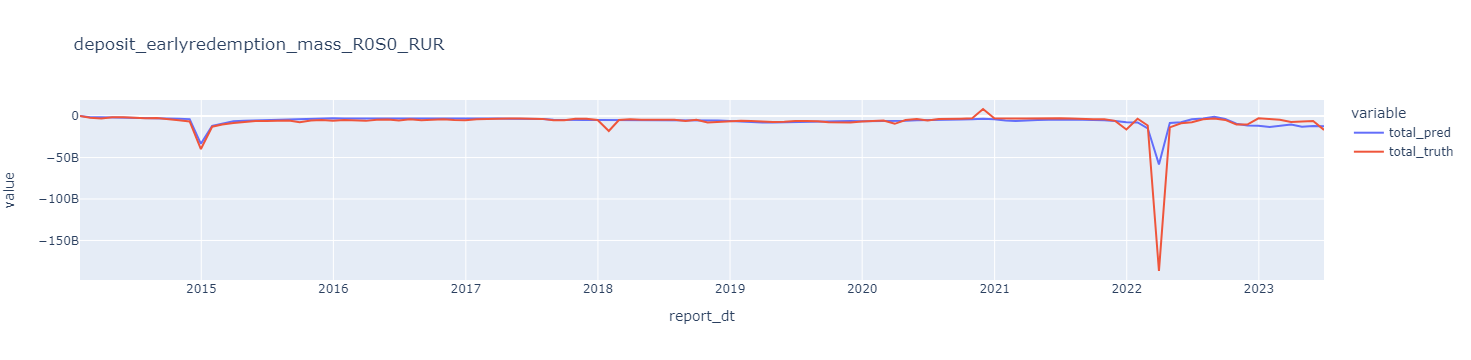

23/12/19 23:33:29 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/4537161672140498350.parquet/*], useFusionForURI: [true]
23/12/19 23:33:30 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/4537161672140498350.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_1556004630_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:33:32 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/4537161672140498350.parquet], useFusionForURI: [true]
23/12/19 23:33:32 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/4537161672140498350.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_1126787933_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23

модель "deposit_earlyredemption_mass_R0S1_RUR" - не получилось обучить модель


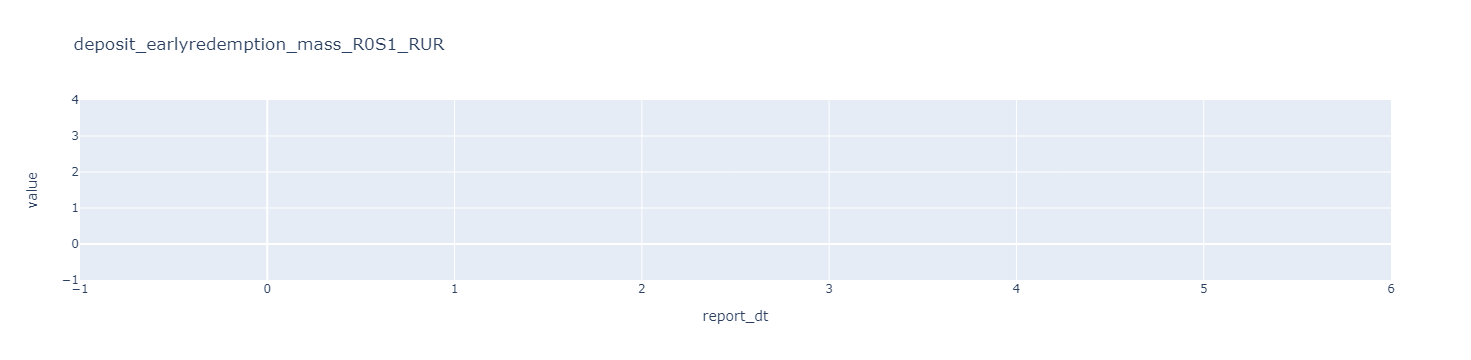

23/12/19 23:33:50 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/4593455215281930824.parquet/*], useFusionForURI: [true]
23/12/19 23:33:51 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/4593455215281930824.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_943402452_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:33:53 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/4593455215281930824.parquet], useFusionForURI: [true]
23/12/19 23:33:54 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/4593455215281930824.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1867490702_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23

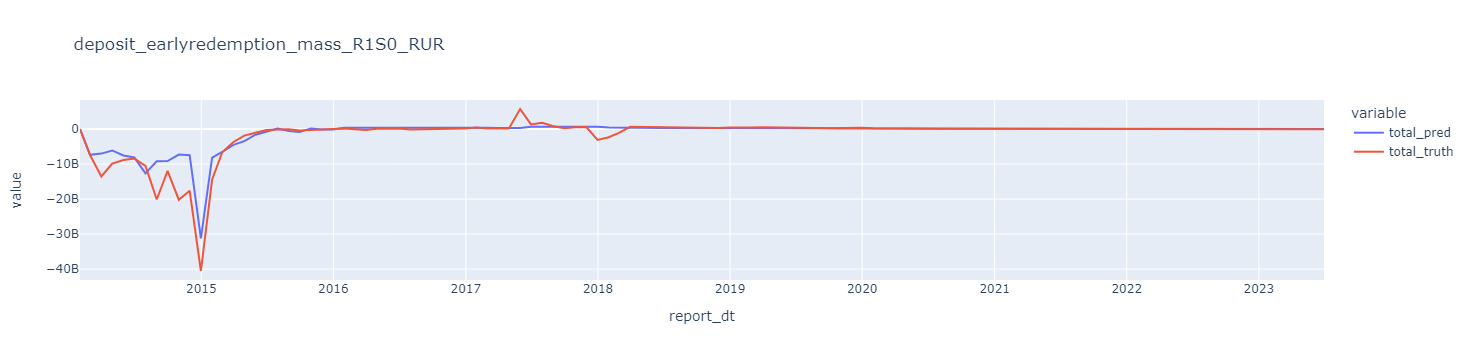

23/12/19 23:34:15 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-1271239491250941609.parquet/*], useFusionForURI: [true]
23/12/19 23:34:16 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-1271239491250941609.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_351809586_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:34:19 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-1271239491250941609.parquet], useFusionForURI: [true]
23/12/19 23:34:19 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-1271239491250941609.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-3801454_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
2

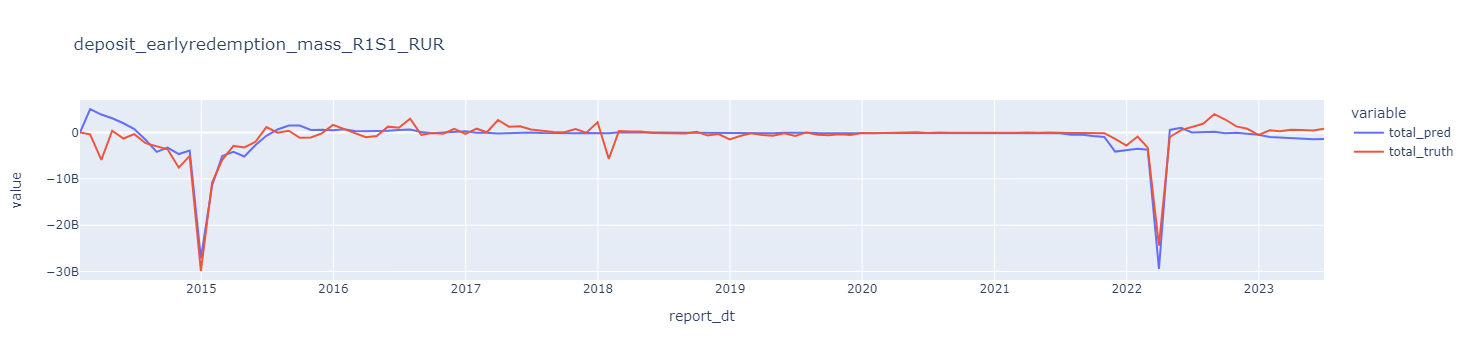

23/12/19 23:34:39 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-6576960094987742460.parquet/*], useFusionForURI: [true]
23/12/19 23:34:39 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-6576960094987742460.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-500166481_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:34:42 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-6576960094987742460.parquet], useFusionForURI: [true]
23/12/19 23:34:42 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-6576960094987742460.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1421864596_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6

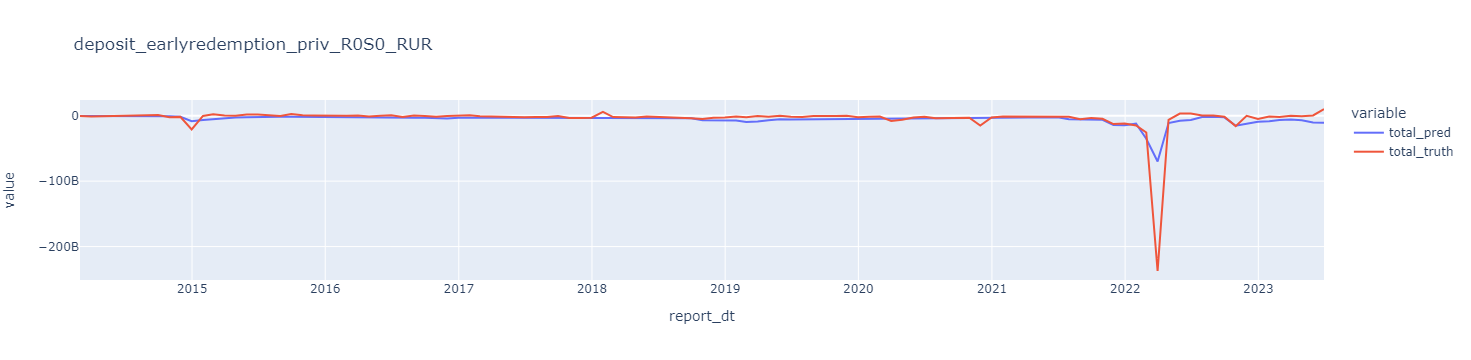

23/12/19 23:34:56 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-1847097592231800705.parquet/*], useFusionForURI: [true]
23/12/19 23:34:56 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-1847097592231800705.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_144871303_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:34:58 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-1847097592231800705.parquet], useFusionForURI: [true]
23/12/19 23:34:59 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-1847097592231800705.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1704706431_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.

модель "deposit_earlyredemption_priv_R0S1_RUR" - не получилось обучить модель


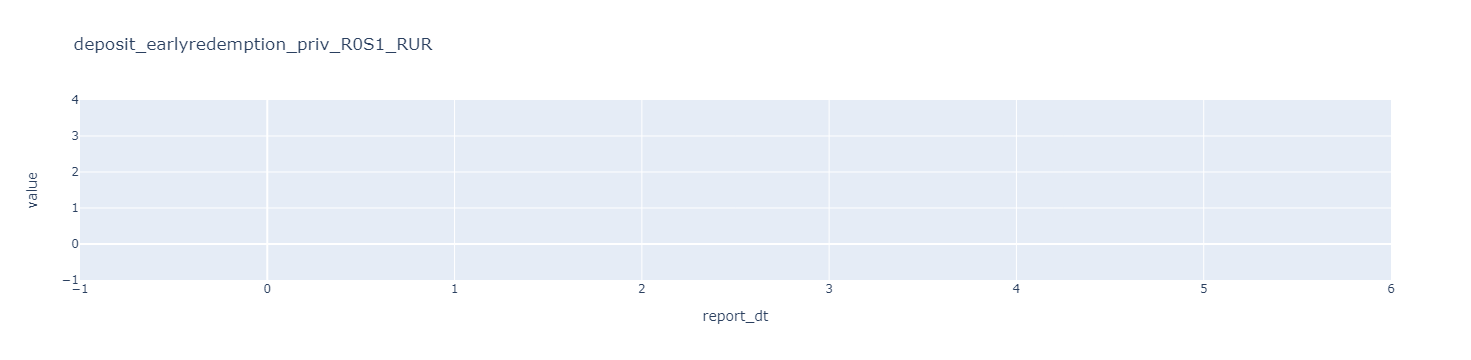

23/12/19 23:35:21 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-6552957674259505226.parquet/*], useFusionForURI: [true]
23/12/19 23:35:21 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-6552957674259505226.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1253331658_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:35:24 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-6552957674259505226.parquet], useFusionForURI: [true]
23/12/19 23:35:24 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-6552957674259505226.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_310752060_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.

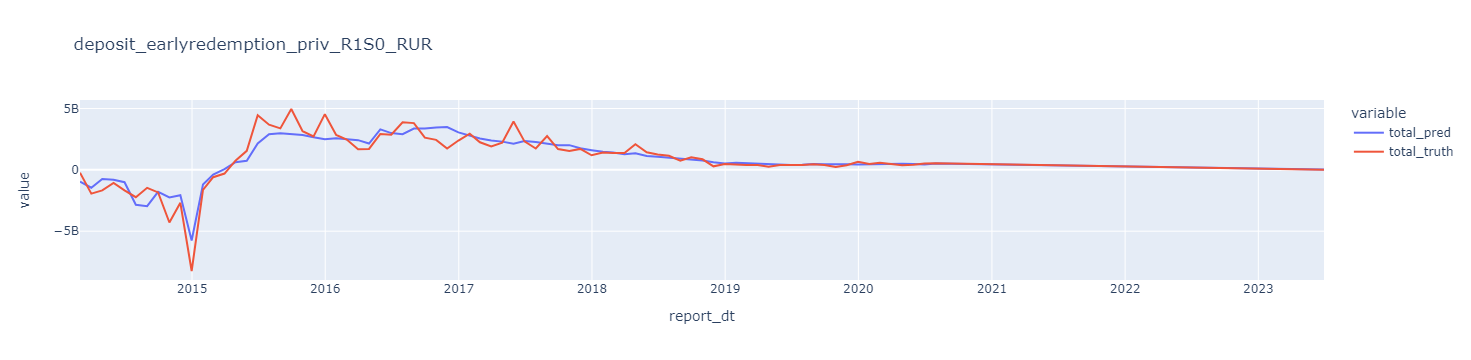

23/12/19 23:35:46 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/4437542348816815864.parquet/*], useFusionForURI: [true]
23/12/19 23:35:46 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/4437542348816815864.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_1088667958_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:35:49 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/4437542348816815864.parquet], useFusionForURI: [true]
23/12/19 23:35:49 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/4437542348816815864.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1395283120_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
2

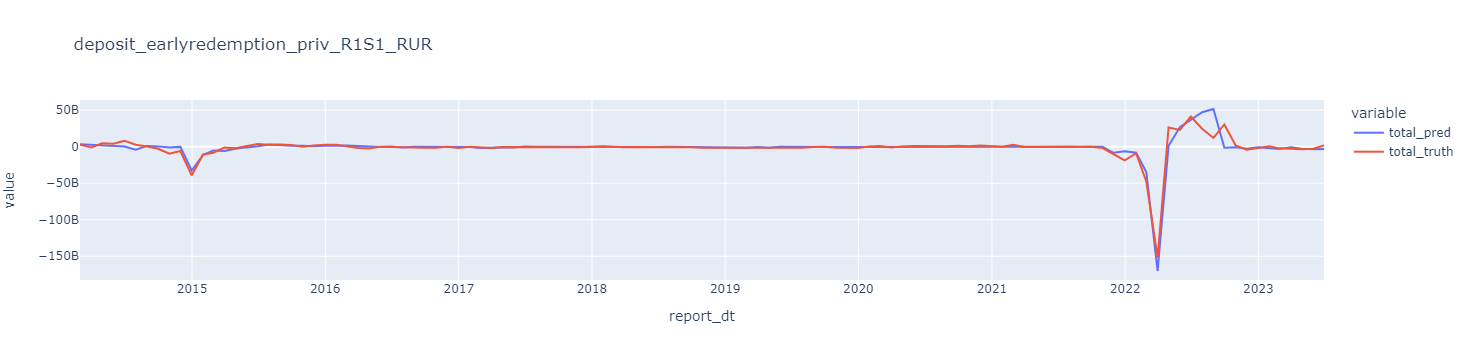

23/12/19 23:36:06 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/1471794468941660730.parquet/*], useFusionForURI: [true]
23/12/19 23:36:07 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/1471794468941660730.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_1070427542_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:36:09 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/1471794468941660730.parquet], useFusionForURI: [true]
23/12/19 23:36:10 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/1471794468941660730.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1404499614_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
2

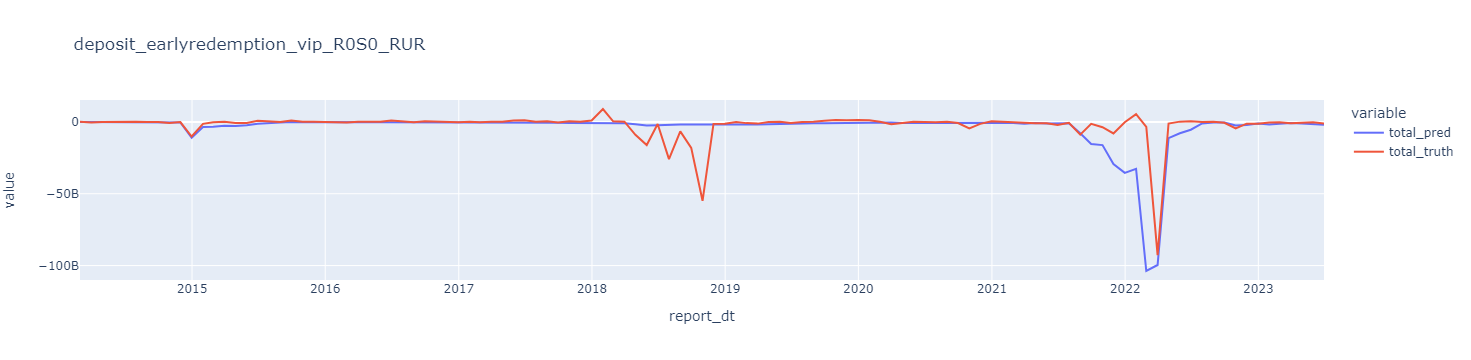

23/12/19 23:36:20 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/875814074342918421.parquet/*], useFusionForURI: [true]
23/12/19 23:36:21 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/875814074342918421.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1891194659_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:36:23 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/875814074342918421.parquet], useFusionForURI: [true]
23/12/19 23:36:24 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/875814074342918421.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1742995236_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/1

модель "deposit_earlyredemption_vip_R0S1_RUR" - не получилось обучить модель


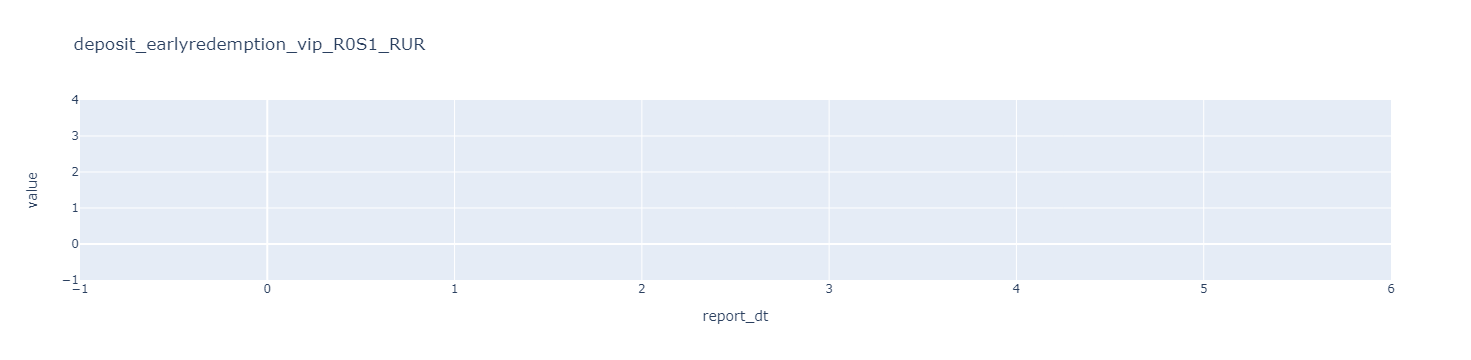

23/12/19 23:36:36 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/2137978591096917517.parquet/*], useFusionForURI: [true]
23/12/19 23:36:36 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/2137978591096917517.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_709159453_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:36:39 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/2137978591096917517.parquet], useFusionForURI: [true]
23/12/19 23:36:39 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/2137978591096917517.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_970163942_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/1

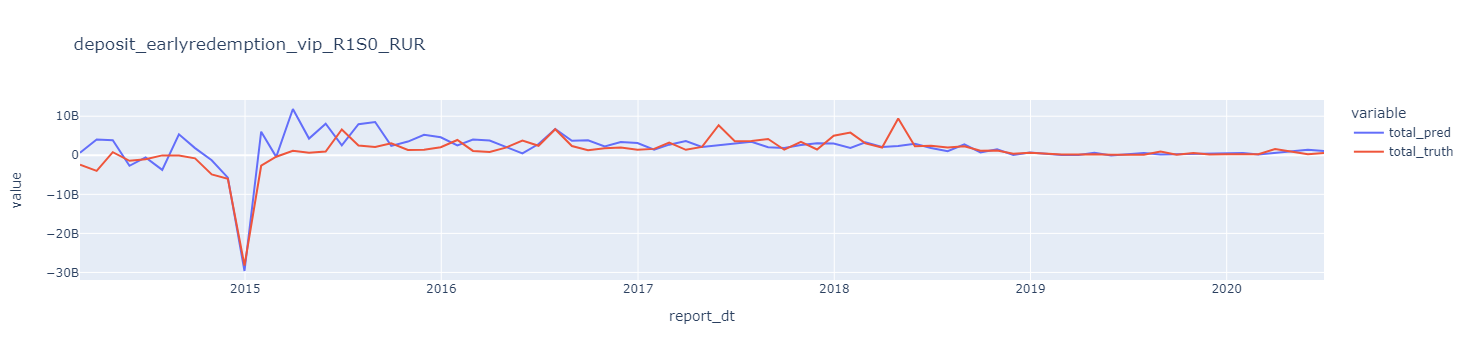

23/12/19 23:36:59 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-4880260954564821161.parquet/*], useFusionForURI: [true]
23/12/19 23:36:59 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-4880260954564821161.parquet/*, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_2026904490_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6.1
23/12/19 23:37:02 INFO client.FusionUriUtils: fs.fusion.check.underlyingFs: [true], URI: [hdfs://adh-users/user/vtb70175290/data/-4880260954564821161.parquet], useFusionForURI: [true]
23/12/19 23:37:02 INFO client.FusionCommonFactory: Initialized FusionHdfs with URI: hdfs://adh-users/user/vtb70175290/data/-4880260954564821161.parquet, FileSystem: DFS[DFSClient[clientName=DFSClient_NONMAPREDUCE_-1721662998_1, ugi=vtb70175290@REGION.VTB.RU (auth:KERBEROS)]], instance: 226690498, version: 2.16.6

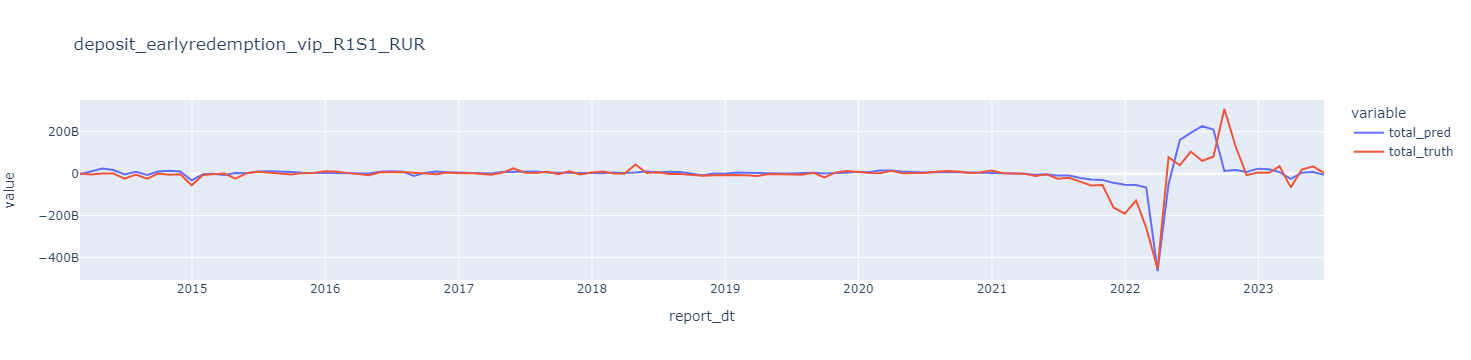

In [20]:
name = 'deposit_earlyredemption_mass_R0S0_RUR'
step = 1
pred_truth_dict = {}

for name in [name for name in DepositModels.model_names if name.startswith('deposit_earlyredemption')]:

    model = engine.register.get_model(engine.trained_models[(step, name)])
    train_df = engine._config.data_loaders[name].get_training_data(spark, engine._config.data_loaders[name].start_date, last_train_dt)['data']
    try:
        preds = model._make_prediction_in_sample(train_df)
    except:
        print(f'модель "{name}" - не получилось обучить модель')
        
    pred_truth = train_df.merge(preds, on = ['gen_name', 'report_dt'])
    
    pred_truth = pred_truth.assign(total_truth = pred_truth['SER_d_cl'], # pred_truth[model.model_class_kwargs['target']] * pred_truth[model.model_class_kwargs['weight_col']], 
                                   total_pred = pred_truth['predictions'] * pred_truth[model.model_class_kwargs['weight_col']])
    
    pred_truth_dict[name] = pred_truth
    
    px.line(pred_truth.groupby('report_dt').agg({'total_pred': 'sum', 'total_truth': 'sum'}), title = name).show()

In [21]:
with open('er_pred_truth.pickle', 'wb') as fo:
    pickle.dump(pred_truth_dict, fo)

In [22]:
model.model_class_kwargs

{'target': 'SER_dinamic_cl',
 'leaf_reg_features': ['incentive', 'incentive_lag1', 'share_period_plan'],
 'splitting_cols': ['share_period_plan',
  'incentive',
  'months_left',
  'incentive_lag1'],
 'splitting_cols_labels': ['shr', 'inc', 'lft', 'lag'],
 'weight_col': 'total_generation_cl_lag1'}

In [21]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_basic_filter_portfolio',
 '_create_renewal_generations',
 '_gen_external_filter',
 '_gen_external_max_rate_scenario',
 '_gen_external_weighted_rate',
 '_gen_inflow_predicted',
 '_gen_pd_filter',
 '_gen_query_expr',
 '_gen_rate_scenario',
 '_make_prediction',
 '_make_prediction_in_sample',
 '_model_info',
 '_model_meta',
 '_port_max_rates',
 '_portfolio_evolution',
 '_single_external_evolution',
 '_split_normal_weird',
 '_unpickle_file_or_buffer',
 'abc_base',
 'balance_buckets',
 'class_name',
 'class_name_prefix',
 'cols_to_split',
 'create_newbusiness_generations',
 'cur',
 'cur_map',
 'date_format',
 'dbase_name',
 '

In [27]:
train_df['SER_dinamic_cl'].mask(train_df['SER_dinamic_cl'] < -1, -1).mask(train_df['SER_dinamic_cl'] > 0, 0)

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4              NaN
            ...   
236354    0.000000
236355         NaN
236356   -0.022432
236357   -0.024701
236358         NaN
Name: SER_dinamic_cl, Length: 209576, dtype: float64

In [22]:
train_df['SER_dinamic_cl'].sum()

-3734.7198159999994